# Coupled Calorimetry and Rheometry data

_Produces Figure 4_

### Import packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter # for scalars in semilogy labels
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import ConnectionPatch
from scipy.optimize import curve_fit

import numpy as np
from pranzo import Analyzer
from bamboost import Manager

import colors as c
from utilities import set_plot_theme, find_closest_index
set_plot_theme()

### Specify the path to the database

The database can be downloaded from the [ETH Research Collection](https://www.research-collection.ethz.ch/)

In [2]:
database_path = ('../out')

db = Manager(database_path)

### Generate the figure

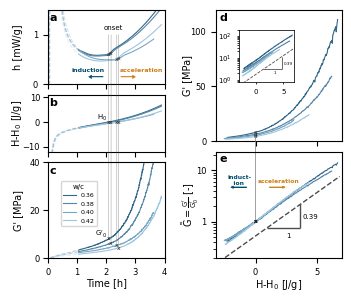

In [3]:
# figure design
fig_results = plt.figure()
fig_results.set_size_inches(90/25.4, 90/25.4) # in mm

lft=0.12 #left limit
rgt=0.95 #right limit
bot=0.2 #bottom limit
top=0.9 #top limit

w_ht = 0.33 # width h-t plot
w_DHt = w_ht # width DH-t plot
w_Gt = w_ht # width G-t plot

h_ht = 0.21 # height h-t
h_DHt = 0.12 # height DH-t
h_Gt = 0.27 # height G-t

h_GDH = 0.37 # height G-DH
w_GDH = 0.395

h_GstarDH = 0.3
w_GstarDH = w_GDH

hspace=0.04
vspace = 0.03

# axis h-t
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=lft, right=lft+w_ht, bottom=top-h_ht, top=top)
ax_ht = plt.subplot(gs1[0,0])

# axis DH-t
gs2 = gridspec.GridSpec(1,1)
gs2.update(left=lft, right=lft+w_DHt, bottom=bot+h_Gt+vspace, top=top-h_ht-vspace)
ax_DHt = plt.subplot(gs2[0,0])

# axis G-t
gs3 = gridspec.GridSpec(1,1)
gs3.update(left=lft, right=lft+w_Gt, bottom=bot, top=bot+h_Gt)
ax_Gt = plt.subplot(gs3[0,0])

# axis G-DH
gs4 = gridspec.GridSpec(1,1)
gs4.update(left=rgt-w_GDH+hspace, right=rgt, bottom=top-h_GDH, top=top)
ax_GDH = plt.subplot(gs4[0,0])

inset_GDH = ax_GDH.inset_axes([0.18, 0.45, 0.44, 0.4])

# axis Gstar-DH
gs5 = gridspec.GridSpec(1,1)
gs5.update(left=rgt-w_GstarDH+hspace, right=rgt, bottom=bot, top=bot+h_GstarDH)
ax_GstarDH = plt.subplot(gs5[0,0])

# Read the data
exps = [db['opc36'], db['opc38'],
        db['opc40'], db['opc42'],
]

# set w/c ratios, onset times and colors
wcs = ['0.36', '0.38', '0.40', '0.42']
onset_times = [7500, 7800, 8500, 8700]
colors = [c.blue36, c.blue38, c.blue40, c.blue42]
fit_params = []

for i in range(len(exps)):
    exp = exps[i]

    a = Analyzer(exp)
    
    # markers design
    x_fntsz=4.5
    x_color = '0.1'

    # get data for time evolutions
    calo = a.calo
    rheo = a.rheo

    t = np.linspace(0, 4*3500, 20000)
    if i == 2:
        t = np.linspace(0, 4*3260, 20000)
    h = calo.interpolate('norm_heat_flow_Wpgbinder', t) 
    H = calo.interpolate('norm_heat_Jpgbinder', t)
    G = rheo.interpolate('storage_modulus_Pa', t, cutoff=0.012)

    idx_calonoise = find_closest_index(t, 3800)
    idx_bump = find_closest_index(t, onset_times[i])

    # plot h-t with markers
    a.myplot(ax=ax_ht, x=t[:idx_calonoise]*a.nft, y=h[:idx_calonoise]*a.nfh,
            c = colors[i], ls='--', alpha=0.3, xlbl='')
    a.myplot(ax=ax_ht, x=t[idx_calonoise:]*a.nft, y=h[idx_calonoise:]*a.nfh,
            c = colors[i], xlbl='')
    ax_ht.text(t[idx_bump]*a.nft, h[idx_bump]*a.nfh, 'x', color=x_color, fontsize=x_fntsz,
                horizontalalignment='center', verticalalignment='center')
    
    # plot H-H0 - t with markers
    DH_dashed = H[:idx_calonoise] - H[idx_bump]
    DH_full = H[idx_calonoise:] - H[idx_bump]

    # plot DH-t with markers
    a.myplot(ax=ax_DHt,
            x=t[:idx_calonoise]*a.nft,
            y=DH_dashed*a.nfH,
            c=colors[i], ls='--', alpha=0.3, xlbl='')

    a.myplot(ax=ax_DHt,
            x=t[idx_calonoise:]*a.nft,
            y=DH_full*a.nfH,
            c=colors[i], ls='-', alpha=1, xlbl='')
    
    ax_DHt.text(t[idx_bump]*a.nft, DH_full[idx_bump-idx_calonoise], 'x', color=x_color, fontsize=x_fntsz,
                horizontalalignment='center', verticalalignment='center')

    # plot G-t with markers
    G_dashed = G[:idx_calonoise]
    G_full = G[idx_calonoise:]

    a.myplot(ax=ax_Gt, x=t[:idx_calonoise]*a.nft, y=G_dashed*a.nfG,
            c = colors[i], ls='--', alpha=0.3)

    a.myplot(ax=ax_Gt, x=t[idx_calonoise:]*a.nft, y=G_full*a.nfG,
            c = colors[i], label=wcs[i])
    
    ax_Gt.text(t[idx_bump]*a.nft, G[idx_bump]*a.nfG, 'x', color=x_color, fontsize=x_fntsz,
                horizontalalignment='center', verticalalignment='center')

    # vlines through time evolutions
    c_line_X_t = '0.3'
    xy_ht = (t[idx_bump]*a.nft, h[idx_bump]*a.nfh)
    xy_Gt = (t[idx_bump]*a.nft, G[idx_bump]*a.nfG)
    con = ConnectionPatch(xyA=xy_ht, xyB=xy_Gt, coordsA="data", coordsB="data",
                            axesA=ax_ht, axesB=ax_Gt, color=c_line_X_t,
                            lw=0.4, linestyle='-', alpha=0.5)
    ax_Gt.add_artist(con)

    # text induction, acceleration, H0, G0
    fntsz_onset = 5
    c_bmp = '0.35'
    xy_ht_1 = (t[idx_bump]*a.nft, h[idx_bump]*a.nfh)
    xy_ht_2 = (t[idx_bump]*a.nft, 1)
    bmp = ConnectionPatch(xyA=xy_ht_1, xyB=xy_ht_2, coordsA="data", coordsB="data",
                            axesA=ax_ht, axesB=ax_ht, color=c_bmp,
                            lw=0.4, linestyle='-', alpha=0.5)
    ax_ht.add_artist(bmp)

    if i == 0:
        ax_ht.text(1.9, 1.1, 'onset', fontsize=fntsz_onset)
        ax_DHt.text(1.7, 1, r"H$_0$", fontsize=fntsz_onset)
        ax_Gt.text(1.6, 9, r"$\mathrm{G}'_0$", fontsize=fntsz_onset, weight='bold')

        c_arrow_induct = c.c_opc_34_accel
        c_arrow_accel = c.c_opc_34_onset
        
        ax_ht.text(0.8, 0.26, 'induction', fontsize=fntsz_onset-0.5, color=c_arrow_induct, weight='bold')
        ax_ht.text(2.45, 0.26, 'acceleration', fontsize=fntsz_onset-0.5, color=c_arrow_accel, weight='bold')

        ax_GstarDH.text(-2.3, 5.2, """induct-
   ion""", fontsize=fntsz_onset-0.7, color=c_arrow_induct, weight='bold')
        ax_GstarDH.text(0.2, 5.7, 'acceleration', fontsize=fntsz_onset-0.7, color=c_arrow_accel, weight='bold')

    # plot G-DH and Gstar-DH with markers
    rheo = a.rheo.phase('p2')
    calo = a.calo

    mytime = np.linspace(3800, 3.85*3600, 20000)
    G = rheo.interpolate('storage_modulus_Pa', mytime, cutoff=0.012)
    H = calo.interpolate('norm_heat_Jpgbinder', mytime)
    idx_bump = find_closest_index(mytime, onset_times[i])
    DH = H - H [idx_bump]
    Gstar = G/G[idx_bump]

    a.myplot(ax=ax_GDH, x=DH*a.nfH, y=G*a.nfG, c=colors[i], xlbl='')
    a.myplot(ax=inset_GDH, x=DH*a.nfH, y=G*a.nfG, type='semilogy',
              xlbl='', ylbl='', c=colors[i])
    
    a.myplot(ax=ax_GstarDH, x=DH*a.nfH, y=Gstar, type='semilogy', 
             c=colors[i], xlbl='')

    ax_GDH.text(DH[idx_bump], G[idx_bump]*a.nfG, 'x', color=x_color, fontsize=x_fntsz,
               horizontalalignment='center', verticalalignment='center')
    
    ax_GstarDH.text(DH[idx_bump], Gstar[idx_bump], 'x', color=x_color, fontsize=x_fntsz,
               horizontalalignment='center', verticalalignment='center')

    # vlines through G-H evolutions

    c_line_X_DH = '0.5'
    xy_GDH = (DH[idx_bump], G[idx_bump]*a.nfG)
    xy_GstarDH = ((DH[idx_bump], Gstar[idx_bump]))
    conGDH = ConnectionPatch(xyA=xy_GDH, xyB=xy_GstarDH, coordsA="data", coordsB="data",
                            axesA=ax_GDH, axesB=ax_GstarDH, color=c_line_X_DH,
                            lw=0.4, linestyle='-', alpha=0.5)
    ax_GstarDH.add_artist(conGDH)


    # add arrows below induction and acceleration
    if i == 0:
        arrow_width = 0.4
        ax_ht.arrow(1.9, 0.15, -arrow_width, 0, linewidth=0.4, 
                     head_width=0.07, 
                     head_length=0.1,
                     color=c_arrow_induct)
        
        ax_ht.arrow(2.5, 0.15, arrow_width, 0, linewidth=0.4, 
                     head_width=0.07, 
                     head_length=0.1,
                     color=c_arrow_accel)

        arrow_width_DH = 1.1
        ax_GstarDH.arrow(-0.7, 4.7, -arrow_width_DH, 0, linewidth=0.5, 
                     head_width=0.5, 
                     head_length=0.2,
                     color=c_arrow_induct)
        
        ax_GstarDH.arrow(1.1, 4.7, arrow_width_DH, 0, linewidth=0.5, 
                     head_width=0.5, 
                     head_length=0.2,
                     color=c_arrow_accel)
                     
    # add straight lines with slope in insets
    def expfit(x, a, b):
        return a*np.exp(b*x)

    # filter NaN values from both arrays
    valid_indices = ~np.isnan(DH) & ~np.isnan(G)
    DH = DH[valid_indices]
    Gstar = Gstar[valid_indices]
    p, pc = curve_fit(expfit, DH, Gstar)
    fit_params.append(p)

# compute average exponent to display as slope
avg_p0 = 0
avg_p1 = 0
for elem in fit_params:
    avg_p0 += elem[0]
    avg_p1 += elem[1]
avg_p0 = avg_p0/len(fit_params)
avg_p1 = avg_p1/len(fit_params)

xx = np.linspace(DH[0]-1, DH[-1]+2.5)
yy = expfit(xx, avg_p0, avg_p1)
c_line = '0.3'
lw_line = 0.6
strt = 5
inset_GDH.semilogy(xx[strt:], yy[strt:]*1.7, '--', c=c_line, lw=lw_line)

uu = 6
lw_triangle = 0.6
inset_ftsz = 3
a1=1

inset_GDH.vlines(0.8*uu, expfit(uu, avg_p0, avg_p1)*0.3, expfit(uu, avg_p0, avg_p1), lw=lw_triangle, color=c_line)
inset_GDH.hlines(expfit(uu, avg_p0, avg_p1)*0.3, 0.22*uu, 0.8*uu, lw=lw_triangle, color=c_line)

inset_GDH.text(0.82*(uu+0.2), expfit(uu-1.7, avg_p0, avg_p1)*0.88, str(round(avg_p1,2)), fontsize=inset_ftsz)
inset_GDH.text(0.66*(uu-1.2), expfit(uu-3.5, avg_p0, avg_p1)*0.7, '1', fontsize=inset_ftsz)

lw_line_big = 1
lw_triangle_big = 1
inset_ftsz_big = 5
a1 = avg_p0 - 0.82
b = avg_p1
yy1 = expfit(xx, a1, b)
ax_GstarDH.semilogy(xx, yy*0.5, '--', c=c_line, lw=lw_line_big)

ax_GstarDH.vlines(0.6*uu, expfit(uu, a1, b)*0.3, 0.9*expfit(uu, a1, b), lw=lw_triangle_big, color=c_line)
ax_GstarDH.hlines(expfit(uu, a1, b)*0.3, 0.15*uu, 0.6*uu, lw=lw_triangle_big, color=c_line)

ax_GstarDH.text(0.6*(uu+0.3), expfit(uu-2.5, a1+0.05, b), str(round(b,2)), fontsize=inset_ftsz_big)
ax_GstarDH.text(0.5*(uu-1), expfit(uu-4.2, a1, b), '1', fontsize=inset_ftsz_big)

# add axes labels
ax_ht.set_ylabel(r"h [mW/g]", labelpad=7)
ax_DHt.set_ylabel(r"H-H$_\mathrm{0}$ [J/g]", labelpad=-1)
ax_Gt.set_ylabel(r"G' [MPa]", labelpad=5)
ax_Gt.set_xlabel(r"Time [h]")

ax_GDH.set_xlabel("")
ax_GDH.set_ylabel(r"G' [MPa]", labelpad=-1)
ax_GstarDH.set_ylabel(r"$\tilde{\mathrm{G}}=\frac{\mathrm{G}'}{\mathrm{G}_0'}$ [-]", labelpad=-4)
ax_GstarDH.set_xlabel(r"H-H$_\mathrm{0}$ [J/g]")

## set axes limits
t_min, t_max = 0, 4

ax_ht.set_xlim(t_min, t_max)
ax_DHt.set_xlim(t_min, t_max)
ax_Gt.set_xlim(t_min, t_max)

ax_ht.set_ylim(0, 1.5)
ax_DHt.set_ylim(-12,11)
ax_Gt.set_ylim(0,40)

DH_xmin, DH_xmax = -3.2, 7

ax_GDH.set_xlim(DH_xmin, DH_xmax)
ax_GstarDH.set_xlim(DH_xmin, DH_xmax)
ax_GDH.set_ylim(0, 120)
ax_GstarDH.set_ylim(0.2, 23)

inset_GDH.set_xlim(DH_xmin, DH_xmax)
inset_GDH.set_ylim(0.8, 200)

# adjust axes labels and ticks
ax_ht.tick_params(bottom=True, labelbottom=False)
ax_DHt.tick_params(bottom=True, labelbottom=False)
ax_DHt.tick_params(axis='y', pad=2)
ax_Gt.tick_params(axis='y', pad=2)
ax_GDH.tick_params(bottom=True, labelbottom=False)

ax_ht.locator_params(axis='y', nbins=2)
ax_ht.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_DHt.locator_params(axis='y', nbins=2)
ax_Gt.locator_params(axis='y', nbins=2)
ax_Gt.locator_params(axis='x', nbins=4)

ax_GDH.locator_params(axis='x', nbins=3)
ax_GstarDH.locator_params(axis='x', nbins=3)
ax_GDH.locator_params(axis='y', nbins=4)
inset_GDH.locator_params(axis='x', nbins=3)

inset_GDH.tick_params(axis='x', labelsize=5)
inset_GDH.tick_params(axis='y', labelsize=5)

# make insets nicer
width_inset = 0.55
length_insetticks = 1.6
inset_GDH.tick_params(width=width_inset, which='both', length=length_insetticks)
plt.setp(inset_GDH.spines.values(), lw=width_inset)

# make semilogy yaxis nicer
yticks = [1, 10]
ax_GstarDH.set_yticks(yticks)
ax_GstarDH.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# add legend
ax_Gt.legend(title='w/c', title_fontsize=5, fontsize=4.5,
             bbox_to_anchor=(0.45, 0.3))

# add subfigures labels a, b, c, d, e
fig_results.text(0.126, 0.87, 'a', fontsize=8, weight='bold')
fig_results.text(0.125, 0.63, 'b', fontsize=8, weight='bold')
fig_results.text(0.126, 0.437, 'c', fontsize=8, weight='bold')
fig_results.text(0.605, 0.87, 'd', fontsize=8, weight='bold')
fig_results.text(0.605, 0.47, 'e', fontsize=8, weight='bold')

plt.show()